## Imports and loading data

In [1]:
!pip install -q sentence-transformers

     |████████████████████████████████| 78 kB 2.6 MB/s 
     |████████████████████████████████| 3.1 MB 31.5 MB/s 
     |████████████████████████████████| 3.3 MB 31.5 MB/s 
     |████████████████████████████████| 1.2 MB 21.4 MB/s 
     |████████████████████████████████| 59 kB 5.9 MB/s 
     |████████████████████████████████| 596 kB 36.0 MB/s 
     |████████████████████████████████| 895 kB 37.5 MB/s 


In [2]:
!pip install pickle5 -q

     |████████████████████████████████| 256 kB 5.5 MB/s 


In [3]:
#canonical
import pandas as pd
import numpy as np 

#words/sentences  preprocessing
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

#modeling
from tensorflow.keras import models,layers

#google import
from google.colab import auth
from google.colab import drive
import pickle5 as pickle

In [4]:
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
def plot_loss_metrics(history, title=None):
    """
    used in DL to plot accuracy and metrics
    must be passed the history of the fitted model
    """
    # -- Retrieve metrics used
    metrics = []
    val_metrics = []

    for m in history.history.keys():
        if m.startswith('val_'):
            val_metrics.append(m)
        else:
            metrics.append(m)

    if len(metrics) % 2 != 0:
        row = len(metrics) // 2 + 1

    if len(metrics) % 2 == 0:
        row = len(metrics) // 2

    fig,axs = plt.subplots(row,2,figsize=(13, 4 * row))

    for m,ax in zip(metrics,axs.flat):
        ax.plot(history.history[m])
        ax.plot(history.history[f'val_{m}'])
        ax.set_title(f'Model {m}')
        ax.set_ylabel(f'{m}')
        ax.set_xlabel('Epoch')
        ax.legend(['Train', 'Test'], loc='best')
        ax.grid(axis="x", linewidth=0.5)
        ax.grid(axis="y", linewidth=0.5)

    if len(metrics) % 2 != 0:
        fig.delaxes[axs.flat[-1]]

    if title:
        fig.suptitle(title)

    pass

## Creating embedding for reviews based on sentences embedding

In [ ]:
#load embedding from gdrive
with open('/content/gdrive/MyDrive/FOBOKILLER/data/embeddings.pkl','rb') as file:
  embedding = pickle.load(file)['embeddings']


In [ ]:
#load dataset from gdrive
with open('/content/gdrive/MyDrive/FOBOKILLER/data/scrapping_cleaned_sentences.csv', 'rb') as file:
  dataset = pd.read_csv(file,index_col=0)

dataset.head(3)

,alias,date,rate,review,review_clean,review_sentences
0,le-sud-paris,2018-11-20,5,"Ed W.\nElite 2021\nMiami, FL\n259\n562\n4232\n...",this is not your traditional parisian cooking ...,this is not your traditional parisian cooking ...
1,le-sud-paris,2018-11-20,5,"Ed W.\nElite 2021\nMiami, FL\n259\n562\n4232\n...",this is not your traditional parisian cooking ...,this restaurant is a full on southern france ...
2,le-sud-paris,2018-11-20,5,"Ed W.\nElite 2021\nMiami, FL\n259\n562\n4232\n...",this is not your traditional parisian cooking ...,we were looking for a good boulliabese


In [ ]:
dataset['rate'].shape , embedding.shape

((459349,), TensorShape([459349, 768]))

In [ ]:
#groupby sentences
dataset = dataset.assign(embedding=[*np.array(embedding)])


In [ ]:
dataset = dataset.groupby('review_clean').agg({'review_sentences':list,'embedding':list,'rate':'mean'}).reset_index()

In [ ]:
## Saving the file

with open('/content/gdrive/MyDrive/FOBOKILLER/data/review_embed.pkl','wb') as file:
  pickle.dump(dataset,file)

## loading the embedding previously built

In [9]:
!pwd

/content


In [11]:
with open('drive/MyDrive/FOBOKILLER/data/review_embed.pkl','rb') as file:
  dataset = pickle.load(file)

In [12]:
# Creating balanced dataset
df1=dataset[dataset['rate']==1].sample(3000)
df2=dataset[dataset['rate']==2].sample(3000)
df3=dataset[dataset['rate']==3].sample(3000)
df4=dataset[dataset['rate']==4].sample(3000)
df5=dataset[dataset['rate']==5].sample(3000)

dataset_balanced=pd.concat([df1,df2,df3,df4,df5])
df1.shape,df2.shape,df3.shape,df4.shape,df5.shape,dataset_balanced.shape

((3000, 4), (3000, 4), (3000, 4), (3000, 4), (3000, 4), (15000, 4))

In [97]:
#dataprep
X=np.array(dataset_balanced['embedding'])
y=dataset_balanced['rate']
#Data
#split train test no changed
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.3)
# Pad the training and test embedded sentences
X_train_pad = pad_sequences(X_train, dtype='float32', padding='post', maxlen=30)
X_test_pad = pad_sequences(X_test, dtype='float32', padding='post', maxlen=30)

#ohe
y_cat=to_categorical(y)

In [101]:
np.array(X_train_pad[0]).shape

(30, 768)

## GRU model for multi classification

In [49]:
##ohe
y_train_cat=to_categorical(y_train)
y_test_cat = to_categorical(y_test)

In [50]:
# checking shapes
X_train.shape,X_test.shape,y_train_cat.shape,y_test_cat.shape

((10500,), (4500,), (10500, 6), (4500, 6))

In [25]:
def init_model():
    model = models.Sequential()
    model.add(layers.Masking())
    model.add(layers.GRU(200, return_sequences=True, activation='tanh'))
    model.add(layers.Dropout(.2))
    model.add(layers.GRU(100,return_sequences=True, activation='tanh'))
    model.add(layers.Dropout(.2))
    model.add(layers.GRU(50, activation='tanh'))
    model.add(layers.Dropout(.1))
    model.add(layers.Dense(15, activation='relu'))
    model.add(layers.Dense(6, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    
    return model

model = init_model()

In [26]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=3, restore_best_weights=True)

history = model.fit(X_train_pad, y_train_cat, 
          batch_size = 8,
          epochs=100,
          validation_split=0.3,
          callbacks=[es],
         )

Epoch 1/100
919/919 [==============================] - 60s 42ms/step - loss: 1.0812 - accuracy: 0.5126 - val_loss: 0.9329 - val_accuracy: 0.5773
Epoch 2/100
919/919 [==============================] - 33s 36ms/step - loss: 0.9184 - accuracy: 0.5911 - val_loss: 0.8803 - val_accuracy: 0.6055
Epoch 3/100
919/919 [==============================] - 33s 36ms/step - loss: 0.8657 - accuracy: 0.6194 - val_loss: 0.9015 - val_accuracy: 0.5989
Epoch 4/100
919/919 [==============================] - 33s 36ms/step - loss: 0.8282 - accuracy: 0.6329 - val_loss: 0.8876 - val_accuracy: 0.6081
Epoch 5/100
919/919 [==============================] - 33s 36ms/step - loss: 0.8010 - accuracy: 0.6532 - val_loss: 0.8936 - val_accuracy: 0.6147


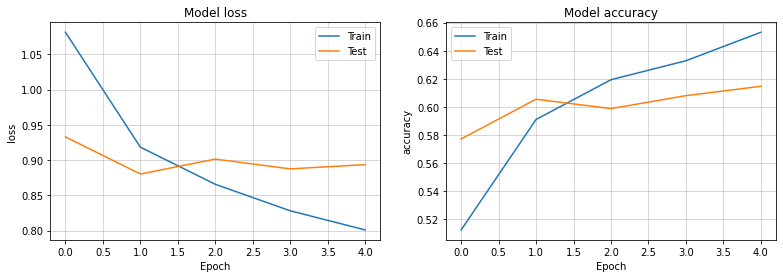

In [31]:
plot_loss_metrics(history)

In [33]:
model.evaluate(X_test_pad,y_test_cat)

141/141 [==============================] - 2s 16ms/step - loss: 0.9040 - accuracy: 0.6044


[0.9039617776870728, 0.6044444441795349]

## GRU model for binary classification



In [51]:
#y binary :
y_train_binary = np.where(y_train<4,0,1)
y_test_binary = np.where(y_test<4,0,1)

In [39]:
def init_model_binary():
    model = models.Sequential()
    model.add(layers.Masking())
    model.add(layers.GRU(200,return_sequences=True, activation='tanh'))
    model.add(layers.Dropout(.2))
    model.add(layers.GRU(100,return_sequences=True, activation='tanh'))
    model.add(layers.Dropout(.2))
    model.add(layers.GRU(50, activation='tanh'))
    model.add(layers.Dropout(.2))
    model.add(layers.Dense(15, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    
    return model

model_binary = init_model_binary()

Epoch 1/100
460/460 [==============================] - 44s 54ms/step - loss: 0.3112 - accuracy: 0.8720 - val_loss: 0.2676 - val_accuracy: 0.8810
Epoch 2/100
460/460 [==============================] - 19s 41ms/step - loss: 0.2546 - accuracy: 0.8955 - val_loss: 0.2498 - val_accuracy: 0.8911
Epoch 3/100
460/460 [==============================] - 19s 41ms/step - loss: 0.2371 - accuracy: 0.9050 - val_loss: 0.2581 - val_accuracy: 0.8930
Epoch 4/100
460/460 [==============================] - 19s 41ms/step - loss: 0.2242 - accuracy: 0.9084 - val_loss: 0.2646 - val_accuracy: 0.8940
Epoch 5/100
460/460 [==============================] - 19s 41ms/step - loss: 0.2055 - accuracy: 0.9156 - val_loss: 0.2846 - val_accuracy: 0.8937
Epoch 6/100
460/460 [==============================] - 19s 41ms/step - loss: 0.1920 - accuracy: 0.9207 - val_loss: 0.2645 - val_accuracy: 0.8889
Epoch 7/100
460/460 [==============================] - 19s 41ms/step - loss: 0.1739 - accuracy: 0.9286 - val_loss: 0.3165 - val_ac

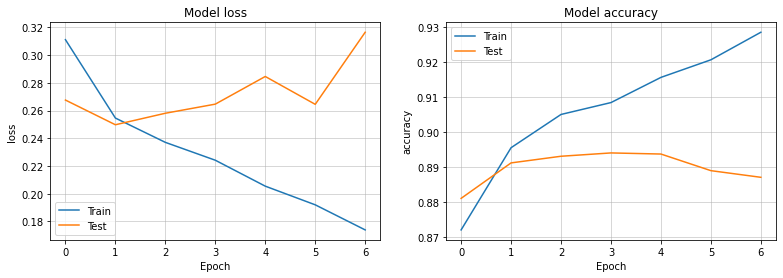

In [40]:
es = EarlyStopping(patience=5, restore_best_weights=True)

history_binary = model_binary.fit(X_train_pad, y_train_binary, 
          batch_size = 16,
          epochs=100,
          validation_split=0.3,
          callbacks=[es]
         )
plot_loss_metrics(history_binary)

0.3983809523809524

In [ ]:
model_binary.evaluate(X_test_pad,y_test_binary)

141/141 [==============================] - 1s 10ms/step - loss: 0.2342 - accuracy: 0.9033


[0.23417919874191284, 0.903333306312561]

## Checking weights

In [69]:
encode = SentenceTransformer('/content/drive/MyDrive/FOBOKILLER/data/model')

In [85]:
def make_heatmap_html(txt, preproc, model):
    txt = pad_sequences(txt, dtype='float32', padding='post', maxlen=30)
    pred = model_binary.predict(txt)
    pad = txt
    class_output = model.output[:]    
    last_conv_layer = model.get_layer("conv1d_92")
    grads = K.gradients(class_output, last_conv_layer.output)[0]    
    pooled_grads = K.mean(grads)    
    iterate = K.function([model.input],[pooled_grads, last_conv_layer.output[0]])    
    pooled_grads_value, conv_layer_output_value = iterate([pad])
    heatmap = np.mean(conv_layer_output_value, axis=-1)    
    heatmap = np.maximum(heatmap, 0)    
    heatmap /= np.max(heatmap)
    # find the ratio of the text vs the conv layer length    norm_len = preproc.max_len/last_conv_layer.output_shape[1]    
    html = ""
    if pred <= 0.4:        
      word_span = "<span style='background-color:rgba(57,160,{},{})'>{} </span>"    
    elif pred <= 0.7:        
      word_span = "<span style='background-color:rgba({},104,83,{})'>{} </span>"    
    else:        
      word_span = "<span style='background-color:rgba({},0,1,{})'>{} </span>"

    for j, i in enumerate(txt.split()):        
      html += word_span.format(heatmap[math.floor(j/norm_len)]*255,                                 
                               heatmap[math.floor(j/norm_len)]-0.3,                                 
                               i)
    return html

In [94]:
np.array(dataset.loc[32,'embedding']).shape

(8, 768)

In [104]:
X_test_pad[0].shape

(30, 768)

In [105]:
model_binary.predict(X_test_pad[0])

ValueError: ignored

In [73]:
dataset.head()

,review_clean,review_sentences,embedding,rate
0,"!!! a theif working amongst you!!! myself, my ...","[ a theif working amongst you, myself, my sis...","[[0.045603834, -0.017338777, 0.0012167644, 0.0...",1.0
1,"""""""""avoid at all costs"""""""""""" this was an absol...","[""""""""avoid at all costs"""""""""""" this was an abso...","[[0.019589972, 0.048924193, -0.015198772, -0.0...",1.0
2,"""$$$"" food but only at a ""$"" price. will be co...","[""$$$"" food but only at a ""$"" price, will be ...","[[0.016501594, 0.1083755, 0.014006043, -0.0319...",5.0
3,"""a middle finger salute"" well i haven't had ma...","[""a middle finger salute"" well i haven't had m...","[[0.019542666, -0.017905522, 0.0037664298, 0.0...",1.0
4,"""a true disappointment and a waste of money an...","[""a true disappointment and a waste of money a...","[[0.036009785, 0.0029092361, 0.0132899275, 0.0...",1.0


In [95]:
txt= pad_sequences(np.array(dataset.loc[2,'embedding']), dtype='float32', padding='post', maxlen=30)
txt.shape

(6, 30)

In [96]:
np.array(dataset.loc[2,'embedding']).shape

(6, 768)

In [ ]:
html = make_heatmap_html(txt, txt, model)